<a href="https://colab.research.google.com/github/melinadwisafitri/skripsi_price_predict/blob/main/beras_super1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Library

In [1]:
import urllib.request
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import math

from keras.utils.vis_utils import plot_model
from tensorflow.data import Dataset
from tensorflow.keras.losses import Huber
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout
from tensorflow.keras.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, RootMeanSquaredError

## time step generator

In [2]:
def time_step_generator(data, time_size, batch_size, shuffle_data):
  dataset = Dataset.from_tensor_slices(data)
  dataset = dataset.window(time_size+1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda x: x.batch(time_size+1))
  dataset = dataset.shuffle(shuffle_data)
  dataset = dataset.map(lambda x: (x[:-1], x[-1]))
  return dataset.batch(batch_size).prefetch(1)

def forecast_predict(model, data, time_size, batch_size):
  generate_data = Dataset.from_tensor_slices(data)
  add_window_step = generate_data.window(time_size, shift=1, drop_remainder=True)
  flatten_window = add_window_step.flat_map(lambda window: window.batch(time_size))
  batch_window = flatten_window.batch(batch_size).prefetch(1)
  model_predict = model.predict(batch_window)
  return model_predict

## Load data

In [3]:
url ='https://github.com/melinadwisafitri/skripsi_price_predict/blob/main/data_pangan/data_fixs/data_new.csv?raw=true'
urllib.request.urlretrieve(url, 'data_pangan.csv')

('data_pangan.csv', <http.client.HTTPMessage at 0x7f58a870faf0>)

In [4]:
dataset = pd.read_csv('data_pangan.csv')
dataset.head()

,date,beras,beras_kualitas_bawah_i,beras_kualitas_bawah_ii,beras_kualitas_medium_i,beras_kualitas_medium_ii,beras_kualitas_super_i,beras_kualitas_super_ii,daging_ayam_ras_segar,daging_sapi_kualitas_1,...,cabai_rawit,cabai_rawit_hijau,cabai_rawit_merah,minyak_goreng,minyak_goreng_curah,minyak_goreng_kemasan_bermerk_1,minyak_goreng_kemasan_bermerk_2,gula_pasir,gula_pasir_kualitas_premium,gula_pasir_lokal
0,2017-01-08,11200,10150,9650,11250,11150,12750,12250,34100,118400,...,41050,34800,47550,13950,12250,15050,14350,14900,16800,13250
1,2017-01-11,11400,10350,9900,11500,11300,12900,12350,30350,117000,...,30000,30000,30450,13900,12250,14950,14300,14500,16550,12900
2,2017-01-12,10700,9650,8500,11200,10950,12250,11850,29350,115800,...,33300,31500,35050,14000,12150,15400,14400,14800,16650,12950
3,2017-02-08,11200,10150,9650,11250,11150,12750,12250,34150,118400,...,40600,34600,46650,13950,12250,15050,14350,14900,16800,13250
4,2017-02-10,11400,10250,9850,11400,11250,12850,12350,30200,118400,...,31850,32550,31550,14000,12350,15000,14350,14700,16750,12950


In [5]:
dataset['date'] = pd.to_datetime(dataset['date'])

In [6]:
dataset = dataset.set_index('date')
dataset = dataset.sort_index()
train = dataset.beras_kualitas_super_i.values
date = dataset.index

## Train test val split

In [7]:
x_train, x_test, y_train, y_test = train_test_split(train, date, test_size=0.2, random_state=False, shuffle=False)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.125, random_state=False, shuffle=False) # 0.125 x 0.48 = 0.1

print(f'{len(x_train)}\n{len(x_test)}')

818
234


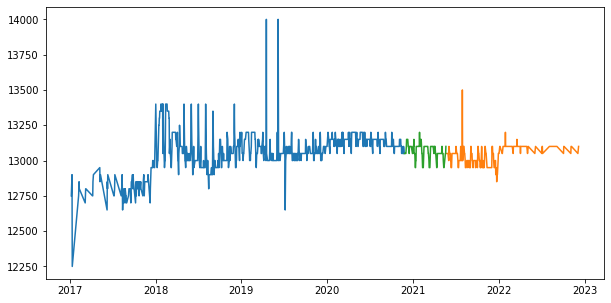

In [8]:
plt.figure(figsize=(10, 5))
plt.plot(y_train, x_train)
plt.plot(y_test, x_test)
plt.plot(y_val, x_val)
plt.show()

## data generate

In [9]:
scal_range= MinMaxScaler(feature_range=(0,1))
train_scal = scal_range.fit_transform(x_train.reshape(-1, 1))
test_scal = scal_range.fit_transform(x_test.reshape(-1, 1))
val_scal = scal_range.fit_transform(x_val.reshape(-1, 1))
train_step = time_step_generator(train_scal, time_size=600, shuffle_data=100, batch_size=5)
val_step = time_step_generator(val_scal, time_size=80, shuffle_data=100, batch_size=20)
test_step = time_step_generator(test_scal, time_size=150, shuffle_data=1000, batch_size=5)

train_step1 = time_step_generator(train_scal, time_size=100, shuffle_data=100, batch_size=1)
val_step1 = time_step_generator(val_scal, time_size=1, shuffle_data=10, batch_size=1)
test_step1 = time_step_generator(test_scal, time_size=10, shuffle_data=100, batch_size=1)

train_step2 = time_step_generator(train_scal, time_size=400, shuffle_data=1000, batch_size=5)
val_step2 = time_step_generator(val_scal, time_size=50, shuffle_data=100, batch_size=2)
test_step2 = time_step_generator(test_scal, time_size=100, shuffle_data=1000, batch_size=5)

In [10]:
forecast = np.append(x_train, x_test)
forecast_date = np.append(y_train, y_test)
win_size= 400
win_size1 = 60
win_size2=150
test_beras_super1_ = scal_range.fit_transform(forecast.reshape(-1, 1))

## model 

### SGD

In [ ]:
model= Sequential([
    Conv1D(16, kernel_size=2, activation='relu',padding='causal', strides=2, input_shape=[None, 1]),
    LSTM(24, return_sequences=True),
    LSTM(20),
    Dense(64, activation='relu'),
    Dense(1)
])

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9), loss='mse', metrics=['mae', 'mape'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 16)          48        
                                                                 
 lstm (LSTM)                 (None, None, 24)          3936      
                                                                 
 lstm_1 (LSTM)               (None, 20)                3600      
                                                                 
 dense (Dense)               (None, 64)                1344      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8,993
Trainable params: 8,993
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# plot_model(model, to_file='model1_plot.png', show_shapes=True, show_layer_names=True)

#### type1

In [ ]:
history = model.fit(train_step, epochs=30, validation_data=val_step)

Epoch 1/30
44/44 [==============================] - 17s 45ms/step - loss: 0.2253 - mae: 0.4727 - mape: 93.5319 - val_loss: 0.1169 - val_mae: 0.3184 - val_mape: 9086300.0000
Epoch 2/30
44/44 [==============================] - 1s 21ms/step - loss: 0.1460 - mae: 0.3805 - mape: 75.2517 - val_loss: 0.0771 - val_mae: 0.2589 - val_mape: 17333056.0000
Epoch 3/30
44/44 [==============================] - 1s 19ms/step - loss: 0.0978 - mae: 0.3114 - mape: 61.5764 - val_loss: 0.0531 - val_mae: 0.2128 - val_mape: 24022932.0000
Epoch 4/30
44/44 [==============================] - 1s 19ms/step - loss: 0.0655 - mae: 0.2542 - mape: 50.2046 - val_loss: 0.0390 - val_mae: 0.1778 - val_mape: 29623656.0000
Epoch 5/30
44/44 [==============================] - 1s 19ms/step - loss: 0.0435 - mae: 0.2067 - mape: 40.8030 - val_loss: 0.0314 - val_mae: 0.1489 - val_mape: 34258800.0000
Epoch 6/30
44/44 [==============================] - 1s 19ms/step - loss: 0.0287 - mae: 0.1674 - mape: 32.9989 - val_loss: 0.0279 - val_

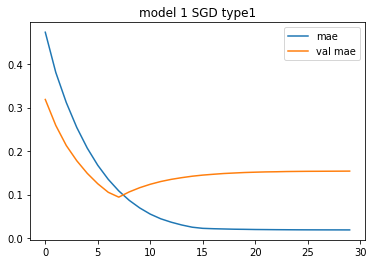

In [ ]:
mae = history.history['mae']
val_mae = history.history['val_mae']
epoch = range(len(mae))

plt.title('model 1 SGD type1')
plt.plot(epoch, mae, label='mae')
plt.plot(epoch, val_mae, label='val mae')
plt.legend()
plt.show()

131/131 [==============================] - 2s 7ms/step
92.718414 0.7129206 111.49150402048579


,date,actual,prediction
0,2021-05-20,13050,13130.551758
1,2021-05-21,13050,13130.769531
2,2021-05-24,13050,13130.361328
3,2021-05-25,13050,13130.429688
4,2021-05-27,13050,13130.135742
...,...,...,...
229,2022-11-02,13100,13130.271484
230,2022-11-03,13100,13130.142578
231,2022-11-04,13100,13130.320312
232,2022-12-01,13050,13130.131836


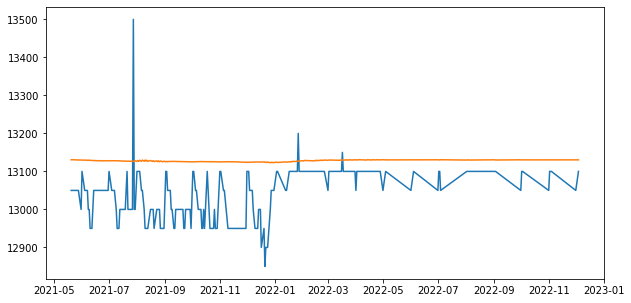

In [ ]:
prediction = forecast_predict(model, test_beras_super1_, time_size=win_size, batch_size=5)

data_result = prediction[(len(x_train))-win_size:-1, -1 ]
data_result = scal_range.inverse_transform(data_result.reshape(-1, 1))
data_result = data_result.reshape(-1)
mae= tf.keras.metrics.mean_absolute_error(x_test, data_result)
mape = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result)
mse = tf.keras.metrics.mean_squared_error(x_test, data_result)

rmse =math.sqrt(mse.numpy())
print(mae.numpy(), mape.numpy(), rmse)

data_new_beras_super1 = pd.DataFrame()
data_new_beras_super1['date'] = y_test
data_new_beras_super1['actual'] = x_test
data_new_beras_super1['prediction'] = data_result
data_new_beras_super1.to_csv('beras_super1_model1_sgd_type1.csv')

plt.figure(figsize=(10, 5))
plt.plot(data_new_beras_super1.date, data_new_beras_super1.actual)
plt.plot(data_new_beras_super1.date, data_new_beras_super1.prediction)
data_new_beras_super1

#### type2

In [ ]:
history_t1 = model.fit(train_step1, epochs=30, validation_data=val_step)

Epoch 1/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0039 - mae: 0.0442 - mape: 9.2252 - val_loss: 0.0377 - val_mae: 0.1465 - val_mape: 52884476.0000
Epoch 2/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0038 - mae: 0.0434 - mape: 9.0126 - val_loss: 0.0375 - val_mae: 0.1458 - val_mape: 52758476.0000
Epoch 3/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0038 - mae: 0.0432 - mape: 8.9394 - val_loss: 0.0378 - val_mae: 0.1466 - val_mape: 52898180.0000
Epoch 4/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0038 - mae: 0.0433 - mape: 8.9928 - val_loss: 0.0375 - val_mae: 0.1456 - val_mape: 52739608.0000
Epoch 5/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0038 - mae: 0.0437 - mape: 9.0495 - val_loss: 0.0375 - val_mae: 0.1458 - val_mape: 52764132.0000
Epoch 6/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0038 - mae: 0.0434 - mape: 8.9988 - val_loss: 0.0376 - val_

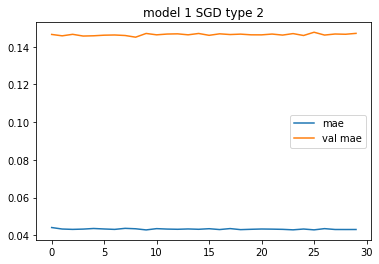

In [ ]:
mae_t1 = history_t1.history['mae']
val_mae_t1 = history_t1.history['val_mae']
epoch_t1 = range(len(mae_t1))

plt.title('model 1 SGD type 2')
plt.plot(epoch_t1, mae_t1, label='mae')
plt.plot(epoch_t1, val_mae_t1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 4ms/step
71.77775 0.55222297 95.09443291736378


,date,actual,prediction
0,2021-05-20,13050,13130.551758
1,2021-05-21,13050,13130.769531
2,2021-05-24,13050,13130.361328
3,2021-05-25,13050,13130.429688
4,2021-05-27,13050,13130.135742
...,...,...,...
229,2022-11-02,13100,13130.271484
230,2022-11-03,13100,13130.142578
231,2022-11-04,13100,13130.320312
232,2022-12-01,13050,13130.131836


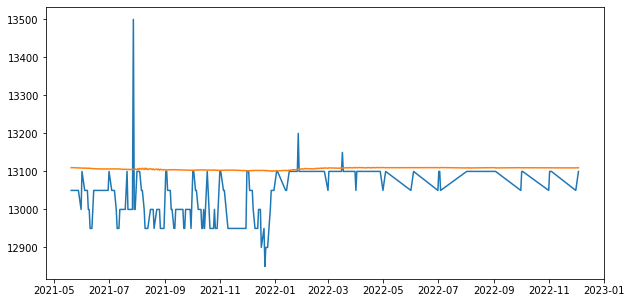

In [ ]:
win_size1 = 60
test_beras_super1_1 = scal_range.fit_transform(forecast.reshape(-1, 1))
prediction_1 = forecast_predict(model, test_beras_super1_1, time_size=win_size1, batch_size=5)

data_result_1 = prediction_1[(len(x_train))-win_size1:-1, -1 ]
data_result_1 = scal_range.inverse_transform(data_result_1.reshape(-1, 1))
data_result_1 = data_result_1.reshape(-1)
mae_1= tf.keras.metrics.mean_absolute_error(x_test, data_result_1)
mape_1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_1)
mse_1 = tf.keras.metrics.mean_squared_error(x_test, data_result_1)
rmse_1 =math.sqrt(mse_1.numpy())
print(mae_1.numpy(), mape_1.numpy(), rmse_1)

data_new_beras_super1_1 = pd.DataFrame()
data_new_beras_super1_1['actual'] = x_test
data_new_beras_super1_1['prediction'] = data_result_1
data_new_beras_super1_1.to_csv('beras_super1_model1_sgd_type2.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_beras_super1_1.actual)
plt.plot(y_test, data_new_beras_super1_1.prediction)
data_new_beras_super1

#### type3

In [ ]:
history_t2 = model.fit(train_step2, epochs=30, validation_data=val_step)

Epoch 1/30
84/84 [==============================] - 1s 15ms/step - loss: 0.0025 - mae: 0.0311 - mape: 6.4359 - val_loss: 0.0375 - val_mae: 0.1459 - val_mape: 52780328.0000
Epoch 2/30
84/84 [==============================] - 1s 14ms/step - loss: 0.0025 - mae: 0.0306 - mape: 6.2941 - val_loss: 0.0372 - val_mae: 0.1448 - val_mape: 52597152.0000
Epoch 3/30
84/84 [==============================] - 1s 14ms/step - loss: 0.0025 - mae: 0.0303 - mape: 6.2333 - val_loss: 0.0370 - val_mae: 0.1443 - val_mape: 52500068.0000
Epoch 4/30
84/84 [==============================] - 1s 14ms/step - loss: 0.0025 - mae: 0.0301 - mape: 6.1649 - val_loss: 0.0369 - val_mae: 0.1439 - val_mape: 52438792.0000
Epoch 5/30
84/84 [==============================] - 1s 15ms/step - loss: 0.0025 - mae: 0.0300 - mape: 6.1584 - val_loss: 0.0368 - val_mae: 0.1436 - val_mape: 52382120.0000
Epoch 6/30
84/84 [==============================] - 1s 14ms/step - loss: 0.0025 - mae: 0.0300 - mape: 6.1393 - val_loss: 0.0368 - val_mae: 0

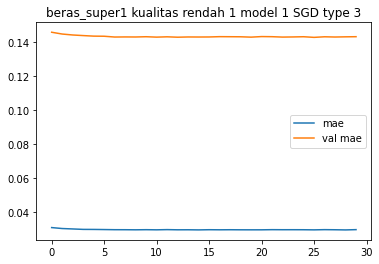

In [ ]:
mae_t2 = history_t2.history['mae']
val_mae_t2 = history_t2.history['val_mae']
epoch_t2 = range(len(mae_t2))

plt.title('beras_super1 kualitas rendah 1 model 1 SGD type 3')
plt.plot(epoch_t2, mae_t2, label='mae')
plt.plot(epoch_t2, val_mae_t2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 1s 5ms/step
64.234886 0.49429137 88.89903584527084


,actual,prediction
0,13050,13100.718750
1,13050,13101.050781
2,13050,13100.468750
3,13050,13100.635742
4,13050,13100.187500
...,...,...
229,13100,13100.407227
230,13100,13100.203125
231,13100,13100.435547
232,13050,13100.189453


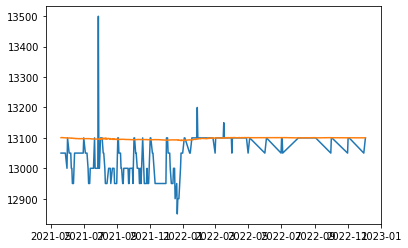

In [ ]:
win_size2 = 150
prediction_2 = forecast_predict(model, test_beras_super1_, time_size=win_size2, batch_size=5)

data_result_2 = prediction_2[(len(x_train))-win_size2:-1, -1 ]
data_result_2 = scal_range.inverse_transform(data_result_2.reshape(-1, 1))
data_result_2 = data_result_2.reshape(-1)
mae_2= tf.keras.metrics.mean_absolute_error(x_test, data_result_2)
mape_2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_2)
mse_2 = tf.keras.metrics.mean_squared_error(x_test, data_result_2)

rmse_2 =math.sqrt(mse_2.numpy())
print(mae_2.numpy(), mape_2.numpy(), rmse_2)

data_new_beras_super1_2 = pd.DataFrame()
# data_new_beras_super11['date'] = date_test
data_new_beras_super1_2['actual'] = x_test
data_new_beras_super1_2['prediction'] = data_result_2
data_new_beras_super1_2.to_csv('beras_super1_model1_sgd_type3')

plt.plot(y_test, data_new_beras_super1_2.actual)
plt.plot(y_test, data_new_beras_super1_2.prediction)
data_new_beras_super1_2

### Adam

In [ ]:
model_a= Sequential([
    Conv1D(16, kernel_size=2, activation='relu',padding='causal', strides=2, input_shape=[None, 1]),
        LSTM(24, return_sequences=True),
        LSTM(20),
        Dense(64, activation='relu'),
        Dense(1)
])

model_a.compile(loss= 'mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=['mae', 'mape'])
model_a.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, None, 16)          48        
                                                                 
 lstm_2 (LSTM)               (None, None, 24)          3936      
                                                                 
 lstm_3 (LSTM)               (None, 20)                3600      
                                                                 
 dense_2 (Dense)             (None, 64)                1344      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8,993
Trainable params: 8,993
Non-trainable params: 0
_________________________________________________________________


#### Type 1

In [ ]:
history_a = model_a.fit(train_step, epochs=30, validation_data=val_step)

Epoch 1/30
44/44 [==============================] - 4s 39ms/step - loss: 0.2089 - mae: 0.4551 - mape: 90.0320 - val_loss: 0.1113 - val_mae: 0.3111 - val_mape: 10435883.0000
Epoch 2/30
44/44 [==============================] - 1s 19ms/step - loss: 0.1118 - mae: 0.3296 - mape: 65.1223 - val_loss: 0.0446 - val_mae: 0.1932 - val_mape: 27671430.0000
Epoch 3/30
44/44 [==============================] - 1s 19ms/step - loss: 0.0158 - mae: 0.1010 - mape: 19.8095 - val_loss: 0.0358 - val_mae: 0.1383 - val_mape: 51863316.0000
Epoch 4/30
44/44 [==============================] - 1s 19ms/step - loss: 5.4881e-04 - mae: 0.0190 - mape: 3.8187 - val_loss: 0.0329 - val_mae: 0.1276 - val_mape: 50014052.0000
Epoch 5/30
44/44 [==============================] - 1s 19ms/step - loss: 5.2612e-04 - mae: 0.0188 - mape: 3.7373 - val_loss: 0.0327 - val_mae: 0.1267 - val_mape: 49849124.0000
Epoch 6/30
44/44 [==============================] - 1s 19ms/step - loss: 5.3767e-04 - mae: 0.0188 - mape: 3.7394 - val_loss: 0.03

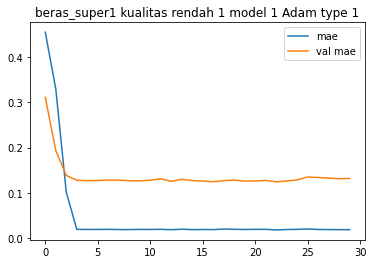

In [ ]:
mae_a = history_a.history['mae']
val_mae_a = history_a.history['val_mae']
epoch_a = range(len(mae_a))

plt.title('beras_super1 kualitas rendah 1 model 1 Adam type 1')
plt.plot(epoch_a, mae_a, label='mae')
plt.plot(epoch_a, val_mae_a, label='val mae')
plt.legend()
plt.show()

131/131 [==============================] - 2s 7ms/step
58.225098 0.4474766 75.84445173758593


,actual,prediction
0,13050,13120.976562
1,13050,13119.895508
2,13050,13119.144531
3,13050,13117.968750
4,13050,13117.082031
...,...,...
229,13100,13111.164062
230,13100,13110.820312
231,13100,13110.959961
232,13050,13110.755859


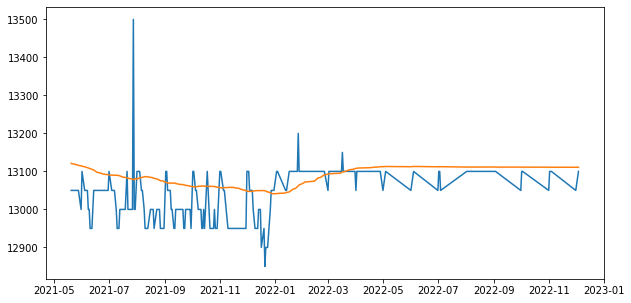

In [ ]:
prediction_a = forecast_predict(model_a, test_beras_super1_, time_size=win_size, batch_size=5)

data_result_a = prediction_a[(len(x_train))-win_size:-1, -1 ]
data_result_a = scal_range.inverse_transform(data_result_a.reshape(-1, 1))
data_result_a = data_result_a.reshape(-1)
mae_a= tf.keras.metrics.mean_absolute_error(x_test, data_result_a)
mape_a = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_a)
mse_a = tf.keras.metrics.mean_squared_error(x_test, data_result_a)

rmse_a =math.sqrt(mse_a.numpy())
print(mae_a.numpy(), mape_a.numpy(), rmse_a)

data_new_beras_super1_a = pd.DataFrame()
# data_new_beras_super11['date'] = date_test
data_new_beras_super1_a['actual'] = x_test
data_new_beras_super1_a['prediction'] = data_result_a
data_new_beras_super1_a.to_csv('beras_super1_model1_adam_type1.csv')

plt.figure(figsize=(10,5))
plt.plot(y_test, data_new_beras_super1_a.actual)
plt.plot(y_test, data_new_beras_super1_a.prediction)
data_new_beras_super1_a

#### Type 2

In [ ]:
history_a1 = model_a.fit(train_step1, epochs=30, validation_data=val_step)

Epoch 1/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0040 - mae: 0.0410 - mape: 8.4175 - val_loss: 0.0346 - val_mae: 0.1340 - val_mape: 51194996.0000
Epoch 2/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0037 - mae: 0.0398 - mape: 8.1161 - val_loss: 0.0343 - val_mae: 0.1325 - val_mape: 50987632.0000
Epoch 3/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0038 - mae: 0.0400 - mape: 8.1653 - val_loss: 0.0336 - val_mae: 0.1298 - val_mape: 50582080.0000
Epoch 4/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0037 - mae: 0.0394 - mape: 8.0403 - val_loss: 0.0356 - val_mae: 0.1366 - val_mape: 51833076.0000
Epoch 5/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0037 - mae: 0.0399 - mape: 8.1504 - val_loss: 0.0347 - val_mae: 0.1330 - val_mape: 51300228.0000
Epoch 6/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0036 - mae: 0.0399 - mape: 8.1868 - val_loss: 0.0354 - val_

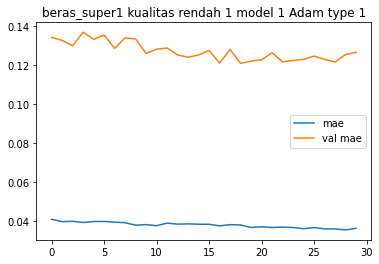

In [ ]:
mae_a1 = history_a1.history['mae']
val_mae_a1 = history_a1.history['val_mae']
epoch_a1 = range(len(mae_a1))

plt.title('beras_super1 kualitas rendah 1 model 1 Adam type 1')
plt.plot(epoch_a1, mae_a1, label='mae')
plt.plot(epoch_a1, val_mae_a1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 4ms/step
91.06874 0.69973123 105.30771038811687


,actual,prediction
0,13050,13157.169922
1,13050,13155.585938
2,13050,13154.634766
3,13050,13152.693359
4,13050,13151.412109
...,...,...
229,13100,13152.182617
230,13100,13151.771484
231,13100,13151.572266
232,13050,13151.755859


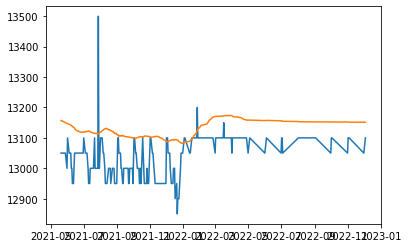

In [ ]:
prediction_a1 = forecast_predict(model_a, test_beras_super1_, time_size=win_size1, batch_size=5)

data_result_a1 = prediction_a1[(len(x_train))-win_size1:-1, -1 ]
data_result_a1 = scal_range.inverse_transform(data_result_a1.reshape(-1, 1))
data_result_a1 = data_result_a1.reshape(-1)
mae_a1= tf.keras.metrics.mean_absolute_error(x_test, data_result_a1)
mape_a1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_a1)
mse_a1 = tf.keras.metrics.mean_squared_error(x_test, data_result_a1)

rmse_a1 =math.sqrt(mse_a1.numpy())
print(mae_a1.numpy(), mape_a1.numpy(), rmse_a1)

data_new_beras_super1_a1 = pd.DataFrame()
data_new_beras_super1_a1['actual'] = x_test
data_new_beras_super1_a1['prediction'] = data_result_a1
data_new_beras_super1_a1.to_csv('beras_super1_model1_adam_type2.csv')

plt.plot(y_test, data_new_beras_super1_a1.actual)
plt.plot(y_test, data_new_beras_super1_a1.prediction)
data_new_beras_super1_a1

#### Type 3

In [ ]:
history_a2 = model_a.fit(train_step2, epochs=30, validation_data=val_step)

Epoch 1/30
84/84 [==============================] - 1s 16ms/step - loss: 0.0022 - mae: 0.0260 - mape: 5.2936 - val_loss: 0.0320 - val_mae: 0.1205 - val_mape: 49321588.0000
Epoch 2/30
84/84 [==============================] - 1s 14ms/step - loss: 0.0023 - mae: 0.0258 - mape: 5.2251 - val_loss: 0.0321 - val_mae: 0.1211 - val_mape: 49442112.0000
Epoch 3/30
84/84 [==============================] - 1s 14ms/step - loss: 0.0023 - mae: 0.0258 - mape: 5.2269 - val_loss: 0.0335 - val_mae: 0.1270 - val_mape: 50465524.0000
Epoch 4/30
84/84 [==============================] - 1s 14ms/step - loss: 0.0023 - mae: 0.0258 - mape: 5.2373 - val_loss: 0.0317 - val_mae: 0.1188 - val_mape: 49037180.0000
Epoch 5/30
84/84 [==============================] - 1s 15ms/step - loss: 0.0023 - mae: 0.0258 - mape: 5.2360 - val_loss: 0.0313 - val_mae: 0.1168 - val_mape: 48699376.0000
Epoch 6/30
84/84 [==============================] - 1s 15ms/step - loss: 0.0023 - mae: 0.0259 - mape: 5.2478 - val_loss: 0.0320 - val_mae: 0

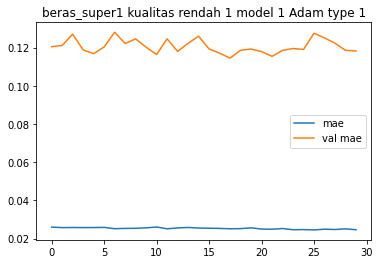

In [ ]:
mae_a2 = history_a2.history['mae']
val_mae_a2 = history_a2.history['val_mae']
epoch_a2 = range(len(mae_a2))

plt.title('beras_super1 kualitas rendah 1 model 1 Adam type 1')
plt.plot(epoch_a2, mae_a2, label='mae')
plt.plot(epoch_a2, val_mae_a2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 1s 5ms/step
46.141068 0.3543207 63.55520368951409


,actual,prediction
0,13050,13096.832031
1,13050,13094.830078
2,13050,13093.873047
3,13050,13091.907227
4,13050,13090.666016
...,...,...
229,13100,13094.862305
230,13100,13095.015625
231,13100,13093.372070
232,13050,13094.367188


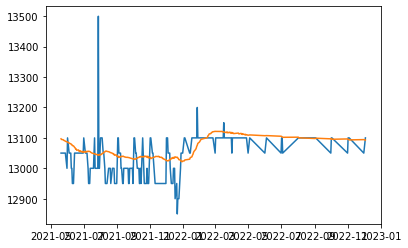

In [ ]:
prediction_a2 = forecast_predict(model_a, test_beras_super1_, time_size=win_size2, batch_size=5)

data_result_a2 = prediction_a2[(len(x_train))-win_size2:-1, -1 ]
data_result_a2 = scal_range.inverse_transform(data_result_a2.reshape(-1, 1))
data_result_a2 = data_result_a2.reshape(-1)
mae_a2= tf.keras.metrics.mean_absolute_error(x_test, data_result_a2)
mape_a2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_a2)
mse_a2 = tf.keras.metrics.mean_squared_error(x_test, data_result_a2)

rmse_a2 =math.sqrt(mse_a2.numpy())
print(mae_a2.numpy(), mape_a2.numpy(), rmse_a2)

data_new_beras_super1_a2 = pd.DataFrame()
# data_new_beras_super11['date'] = date_test
data_new_beras_super1_a2['actual'] = x_test
data_new_beras_super1_a2['prediction'] = data_result_a2
data_new_beras_super1_a2.to_csv('beras_super1_model1_adam_type3.csv')

plt.plot(y_test, data_new_beras_super1_a2.actual)
plt.plot(y_test, data_new_beras_super1_a2.prediction)
data_new_beras_super1_a2

## model 1

### Adam

In [13]:
model1= Sequential([
    Conv1D(16, kernel_size=5, activation='relu', strides=2, input_shape=[None, 1], padding='causal'),
    LSTM(128, return_sequences=True),
    LSTM(32),
    Dense(64, activation='relu'),
    Dense(128, activation='relu'),
    Dense(1)
])

model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='mse', metrics=['mae', 'mape'])
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 16)          96        
                                                                 
 lstm (LSTM)                 (None, None, 128)         74240     
                                                                 
 lstm_1 (LSTM)               (None, 32)                20608     
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 105,505
Trainable params: 105,505
Non-trai

#### Type 1

In [ ]:
history1 = model1.fit(train_step, epochs=15, validation_data=val_step)

Epoch 1/15
44/44 [==============================] - 5s 43ms/step - loss: 0.1638 - mae: 0.3930 - mape: 77.6176 - val_loss: 0.0299 - val_mae: 0.1403 - val_mape: 35568884.0000
Epoch 2/15
44/44 [==============================] - 1s 22ms/step - loss: 0.0039 - mae: 0.0472 - mape: 9.3201 - val_loss: 0.0349 - val_mae: 0.1369 - val_mape: 51161432.0000
Epoch 3/15
44/44 [==============================] - 1s 22ms/step - loss: 5.5173e-04 - mae: 0.0191 - mape: 3.8135 - val_loss: 0.0325 - val_mae: 0.1278 - val_mape: 49584864.0000
Epoch 4/15
44/44 [==============================] - 1s 22ms/step - loss: 5.5021e-04 - mae: 0.0194 - mape: 3.8621 - val_loss: 0.0329 - val_mae: 0.1296 - val_mape: 49892676.0000
Epoch 5/15
44/44 [==============================] - 1s 22ms/step - loss: 5.3228e-04 - mae: 0.0189 - mape: 3.7503 - val_loss: 0.0331 - val_mae: 0.1302 - val_mape: 50006784.0000
Epoch 6/15
44/44 [==============================] - 1s 22ms/step - loss: 5.4140e-04 - mae: 0.0191 - mape: 3.8073 - val_loss: 0.

17/17 [==============================] - 0s 7ms/step - loss: 0.0033 - mae: 0.0433 - mape: 11.7598


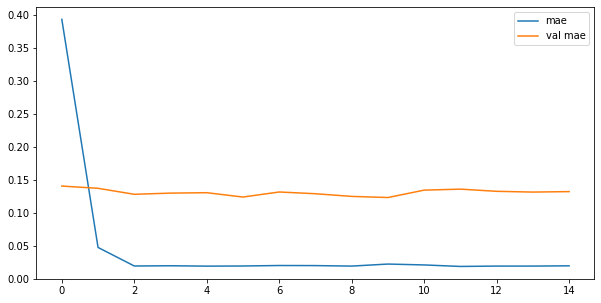

In [ ]:
model1.evaluate(test_step)
mae1 = history1.history['mae']
val_mae1 = history1.history['val_mae']
epoch1 = range(len(mae1))

plt.figure(figsize=(10, 5))
plt.plot(epoch1, mae1, label='mae')
plt.plot(epoch1, val_mae1, label='val mae')
plt.legend()
plt.show()

In [ ]:
prediction1 = forecast_predict(model1, test_beras_super1_, time_size=win_size, batch_size=5)

data_result1 = prediction1[(len(x_train))-win_size:-1, -1 ]
data_result1 = scal_range.inverse_transform(data_result1.reshape(-1, 1))
data_result1 = data_result1.reshape(-1)
mae1 = tf.keras.metrics.mean_absolute_error(x_test, data_result1)
mape1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1)
mse1 = tf.keras.metrics.mean_squared_error(x_test, data_result1)

rmse1 = math.sqrt(mse1.numpy())
print(mae1.numpy(), mape1.numpy(), rmse1)

data_new_beras_super11 = pd.DataFrame()
data_new_beras_super11['actual'] = x_test
data_new_beras_super11['prediction'] = data_result1
data_new_beras_super11.to_csv('beras_super1_model2_adam_type1.csv')

data_new_beras_super11

131/131 [==============================] - 2s 8ms/step
57.529697 0.44204965 74.23370572998662


,actual,prediction
0,13050,13074.476562
1,13050,13074.508789
2,13050,13074.327148
3,13050,13074.343750
4,13050,13074.156250
...,...,...
229,13100,13072.648438
230,13100,13072.694336
231,13100,13072.667969
232,13050,13072.696289


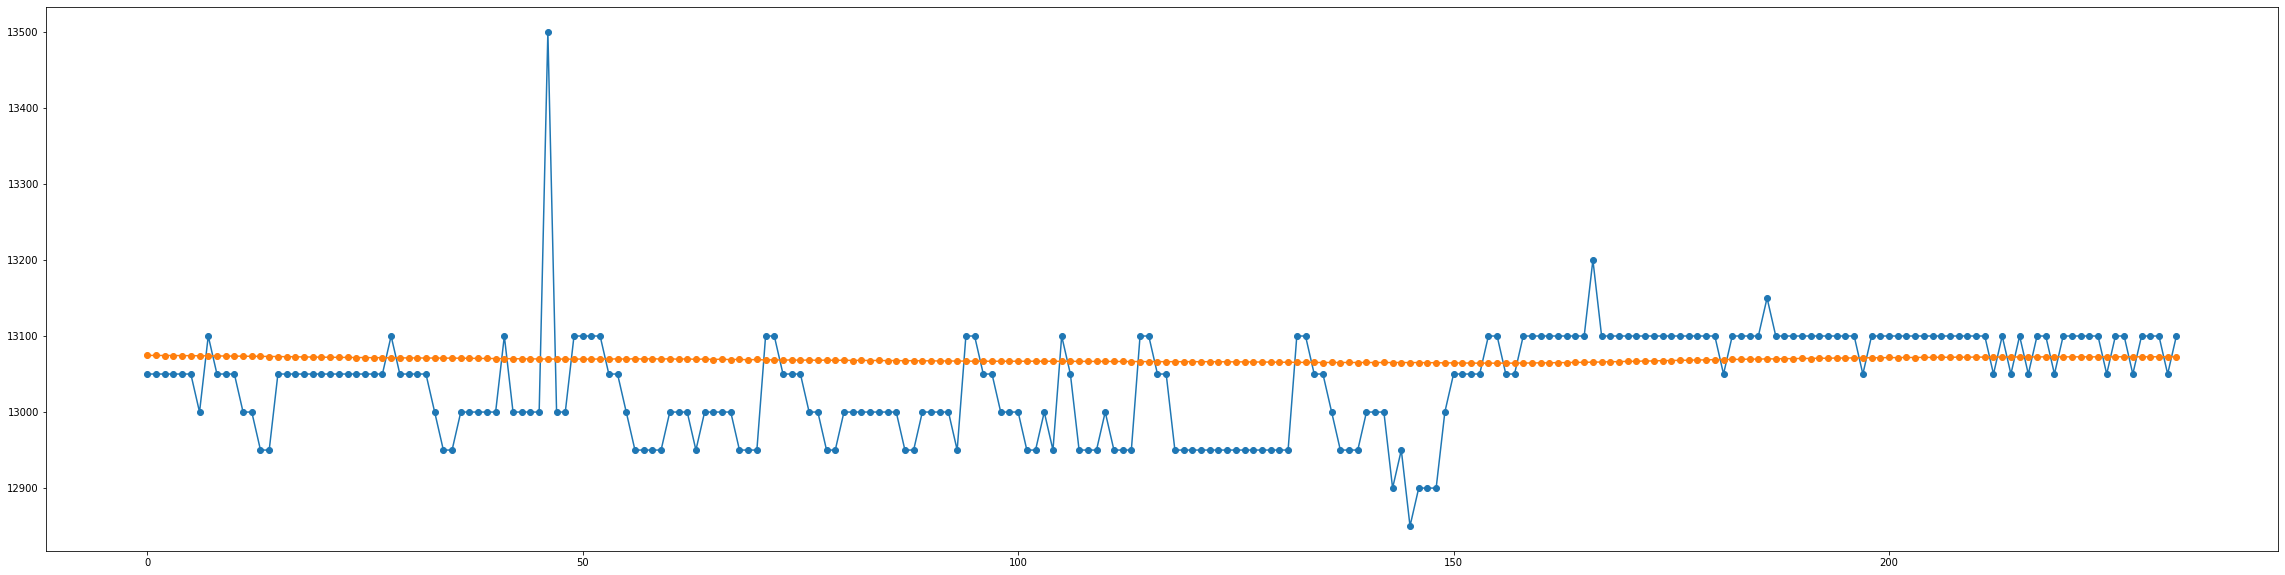

In [ ]:
plt.figure(figsize=(40, 10))
plt.plot(range(len(x_test)), data_new_beras_super11['actual'], '-o')
plt.plot(range(len(x_test)), data_new_beras_super11['prediction'], '-o')

#### Type 2

In [ ]:
history1_1 = model1.fit(train_step1, epochs=15, validation_data=val_step)

Epoch 1/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0043 - mae: 0.0434 - mape: 8.8912 - val_loss: 0.0397 - val_mae: 0.1519 - val_mape: 53837536.0000
Epoch 2/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0041 - mae: 0.0430 - mape: 8.8407 - val_loss: 0.0347 - val_mae: 0.1362 - val_mape: 51138068.0000
Epoch 3/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0040 - mae: 0.0425 - mape: 8.7547 - val_loss: 0.0315 - val_mae: 0.1234 - val_mape: 48945088.0000
Epoch 4/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0039 - mae: 0.0417 - mape: 8.5580 - val_loss: 0.0357 - val_mae: 0.1396 - val_mape: 51791424.0000
Epoch 5/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0039 - mae: 0.0413 - mape: 8.4979 - val_loss: 0.0385 - val_mae: 0.1481 - val_mape: 53309668.0000
Epoch 6/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0038 - mae: 0.0418 - mape: 8.5749 - val_loss: 0.0425 - val_

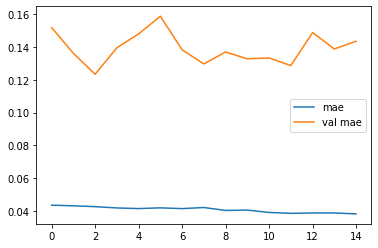

In [ ]:
mae1_1 = history1_1.history['mae']
val_mae1_1 = history1_1.history['val_mae']
epoch1_1 = range(len(mae1_1))

plt.plot(epoch1_1, mae1_1, label='mae')
plt.plot(epoch1_1, val_mae1_1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 3ms/step
61.289894 0.4714066 74.23370572998662


,actual,prediction
0,13050,13088.182617
1,13050,13088.255859
2,13050,13088.083008
3,13050,13088.096680
4,13050,13087.901367
...,...,...
229,13100,13088.082031
230,13100,13087.835938
231,13100,13088.074219
232,13050,13087.797852


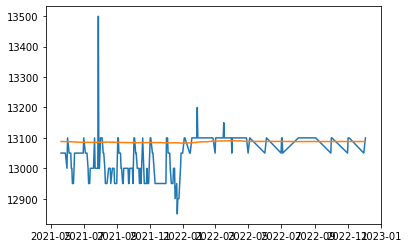

In [ ]:
prediction1_1 = forecast_predict(model1, test_beras_super1_, time_size=win_size1, batch_size=5)

data_result1_1 = prediction1_1[(len(x_train))-win_size1:-1, -1 ]
data_result1_1 = scal_range.inverse_transform(data_result1_1.reshape(-1, 1))
data_result1_1 = data_result1_1.reshape(-1)
mae1_1 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_1)
mape1_1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_1)
mse1_1 = tf.keras.metrics.mean_squared_error(x_test, data_result1_1)

rmse1_1 = math.sqrt(mse1.numpy())
print(mae1_1.numpy(), mape1_1.numpy(), rmse1_1)

data_new_beras_super11_1 = pd.DataFrame()
data_new_beras_super11_1['actual'] = x_test
data_new_beras_super11_1['prediction'] = data_result1_1
data_new_beras_super11_1.to_csv('beras_super1_model2_adam_type2.csv')

plt.plot(y_test, data_new_beras_super11_1.actual)
plt.plot(y_test, data_new_beras_super11_1.prediction)
data_new_beras_super11_1

#### Type 3

In [14]:
history1_2 = model1.fit(train_step2, epochs=15, validation_data=val_step)

Epoch 1/15
84/84 [==============================] - 14s 29ms/step - loss: 0.0810 - mae: 0.2165 - mape: 44.3821 - val_loss: 0.0342 - val_mae: 0.1356 - val_mape: 50704136.0000
Epoch 2/15
84/84 [==============================] - 2s 17ms/step - loss: 0.0024 - mae: 0.0283 - mape: 5.7849 - val_loss: 0.0310 - val_mae: 0.1227 - val_mape: 48444880.0000
Epoch 3/15
84/84 [==============================] - 1s 15ms/step - loss: 0.0025 - mae: 0.0289 - mape: 5.8701 - val_loss: 0.0329 - val_mae: 0.1305 - val_mape: 49791196.0000
Epoch 4/15
84/84 [==============================] - 1s 16ms/step - loss: 0.0024 - mae: 0.0289 - mape: 5.9063 - val_loss: 0.0323 - val_mae: 0.1281 - val_mape: 49381148.0000
Epoch 5/15
84/84 [==============================] - 1s 16ms/step - loss: 0.0024 - mae: 0.0286 - mape: 5.8027 - val_loss: 0.0327 - val_mae: 0.1300 - val_mape: 49716236.0000
Epoch 6/15
84/84 [==============================] - 1s 15ms/step - loss: 0.0024 - mae: 0.0276 - mape: 5.6293 - val_loss: 0.0328 - val_mae:

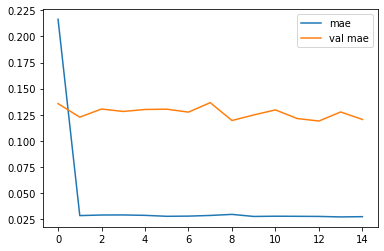

In [15]:
mae1_2 = history1_2.history['mae']
val_mae1_2 = history1_2.history['val_mae']
epoch1_2 = range(len(mae1_2))

plt.plot(epoch1_2, mae1_2, label='mae')
plt.plot(epoch1_2, val_mae1_2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 1s 5ms/step
53.668682 0.4118123 67.18683865953584


,actual,prediction
0,13050,13098.173828
1,13050,13097.990234
2,13050,13097.065430
3,13050,13096.922852
4,13050,13095.845703
...,...,...
229,13100,13085.469727
230,13100,13085.781250
231,13100,13085.346680
232,13050,13085.668945


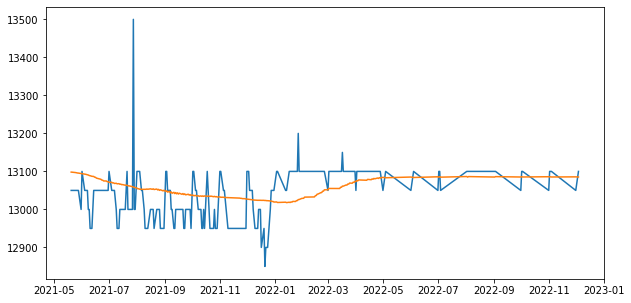

In [16]:
prediction1_2 = forecast_predict(model1, test_beras_super1_, time_size=win_size2, batch_size=5)

data_result1_2 = prediction1_2[(len(x_train))-win_size2:-1, -1 ]
data_result1_2 = scal_range.inverse_transform(data_result1_2.reshape(-1, 1))
data_result1_2 = data_result1_2.reshape(-1)
mae1_2 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_2)
mape1_2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_2)
mse1_2 = tf.keras.metrics.mean_squared_error(x_test, data_result1_2)
rmse1_2 = math.sqrt(mse1_2.numpy())
print(mae1_2.numpy(), mape1_2.numpy(), rmse1_2)

data_new_beras_super11_2 = pd.DataFrame()
data_new_beras_super11_2['actual'] = x_test
data_new_beras_super11_2['prediction'] = data_result1_2
data_new_beras_super11_2.to_csv('beras_super1_model2_adam_type3.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_beras_super11_2.actual)
plt.plot(y_test, data_new_beras_super11_2.prediction)

data_new_beras_super11_2

### SGD

In [ ]:
model1_a= Sequential([
    Conv1D(16, kernel_size=5, activation='relu', strides=2, input_shape=[None, 1], padding='causal'),
    LSTM(128, return_sequences=True),
    LSTM(32),
    Dense(64, activation='relu'),
    Dense(128, activation='relu'),
    Dense(1)
])

model1_a.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9), loss='mse', metrics=['mae', 'mape'])
model1_a.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, None, 16)          96        
                                                                 
 lstm_6 (LSTM)               (None, None, 128)         74240     
                                                                 
 lstm_7 (LSTM)               (None, 32)                20608     
                                                                 
 dense_7 (Dense)             (None, 64)                2112      
                                                                 
 dense_8 (Dense)             (None, 128)               8320      
                                                                 
 dense_9 (Dense)             (None, 1)                 129       
                                                                 
Total params: 105,505
Trainable params: 105,505
Non-tr

In [ ]:
# plot_model(model1, to_file='model2_plot.png', show_shapes=True, show_layer_names=True)

#### Type1 

In [ ]:
history1_a = model1_a.fit(train_step, epochs=15, validation_data=val_step)

Epoch 1/15
44/44 [==============================] - 4s 41ms/step - loss: 0.2292 - mae: 0.4770 - mape: 94.3932 - val_loss: 0.1205 - val_mae: 0.3229 - val_mape: 8415424.0000
Epoch 2/15
44/44 [==============================] - 1s 21ms/step - loss: 0.1496 - mae: 0.3851 - mape: 76.1614 - val_loss: 0.0779 - val_mae: 0.2603 - val_mape: 17087366.0000
Epoch 3/15
44/44 [==============================] - 1s 21ms/step - loss: 0.0985 - mae: 0.3124 - mape: 61.7573 - val_loss: 0.0531 - val_mae: 0.2126 - val_mape: 24012054.0000
Epoch 4/15
44/44 [==============================] - 1s 21ms/step - loss: 0.0650 - mae: 0.2532 - mape: 50.0138 - val_loss: 0.0388 - val_mae: 0.1771 - val_mape: 29711640.0000
Epoch 5/15
44/44 [==============================] - 1s 21ms/step - loss: 0.0427 - mae: 0.2047 - mape: 40.3960 - val_loss: 0.0312 - val_mae: 0.1478 - val_mape: 34398492.0000
Epoch 6/15
44/44 [==============================] - 1s 21ms/step - loss: 0.0279 - mae: 0.1648 - mape: 32.4920 - val_loss: 0.0278 - val_m

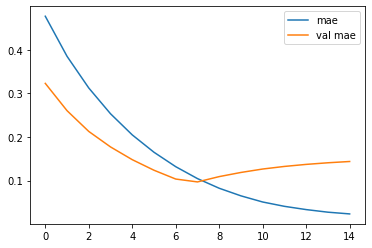

In [ ]:
mae1_a = history1_a.history['mae']
val_mae1_a = history1_a.history['val_mae']
epoch1_a = range(len(mae1_a))

plt.plot(epoch1_a, mae1_a, label='mae')
plt.plot(epoch1_a, val_mae1_a, label='val mae')
plt.legend()
plt.show()

131/131 [==============================] - 2s 7ms/step
58.25436 0.44769043 75.65831200721604


,actual,prediction
0,13050,13071.919922
1,13050,13071.871094
2,13050,13071.875977
3,13050,13071.839844
4,13050,13071.822266
...,...,...
229,13100,13071.756836
230,13100,13071.756836
231,13100,13071.752930
232,13050,13071.752930


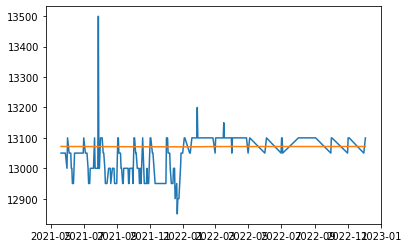

In [ ]:
prediction1_a = forecast_predict(model1_a, test_beras_super1_, time_size=win_size, batch_size=5)

data_result1_a = prediction1_a[(len(x_train))-win_size:-1, -1 ]
data_result1_a = scal_range.inverse_transform(data_result1_a.reshape(-1, 1))
data_result1_a = data_result1_a.reshape(-1)
mae1_a = tf.keras.metrics.mean_absolute_error(x_test, data_result1_a)
mape1_a = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_a)
mse1_a = tf.keras.metrics.mean_squared_error(x_test, data_result1_a)

rmse1_a = math.sqrt(mse1_a.numpy())
print(mae1_a.numpy(), mape1_a.numpy(), rmse1_a)

data_new_beras_super11_a = pd.DataFrame()
data_new_beras_super11_a['actual'] = x_test
data_new_beras_super11_a['prediction'] = data_result1_a
data_new_beras_super11_a.to_csv('beras_super1_model2_sgd_type1.csv')


plt.plot(y_test, data_new_beras_super11_a.actual)
plt.plot(y_test, data_new_beras_super11_a.prediction)

data_new_beras_super11_a

#### Type 2


In [ ]:
history1_a1 = model1_a.fit(train_step1, epochs=15, validation_data=val_step)

Epoch 1/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0038 - mae: 0.0427 - mape: 8.8126 - val_loss: 0.0381 - val_mae: 0.1476 - val_mape: 53019480.0000
Epoch 2/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0038 - mae: 0.0432 - mape: 8.9545 - val_loss: 0.0378 - val_mae: 0.1468 - val_mape: 52901752.0000
Epoch 3/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0038 - mae: 0.0431 - mape: 8.9090 - val_loss: 0.0381 - val_mae: 0.1477 - val_mape: 53052476.0000
Epoch 4/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0038 - mae: 0.0432 - mape: 8.9480 - val_loss: 0.0381 - val_mae: 0.1478 - val_mape: 53065048.0000
Epoch 5/15
718/718 [==============================] - 6s 8ms/step - loss: 0.0038 - mae: 0.0435 - mape: 9.0271 - val_loss: 0.0380 - val_mae: 0.1473 - val_mape: 52975956.0000
Epoch 6/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0038 - mae: 0.0432 - mape: 8.9415 - val_loss: 0.0380 - val_

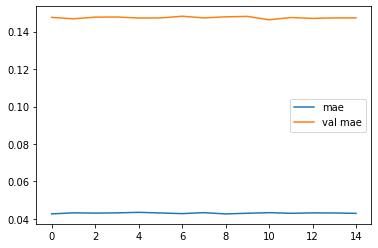

In [ ]:
mae1_a1 = history1_a1.history['mae']
val_mae1_a1 = history1_a1.history['val_mae']
epoch1_a1 = range(len(mae1_a1))

plt.plot(epoch1_a1, mae1_a1, label='mae')
plt.plot(epoch1_a1, val_mae1_a1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 4ms/step
58.51432 0.44971612 76.1126965632213


,actual,prediction
0,13050,13073.022461
1,13050,13072.974609
2,13050,13072.968750
3,13050,13072.935547
4,13050,13072.908203
...,...,...
229,13100,13072.854492
230,13100,13072.849609
231,13100,13072.847656
232,13050,13072.842773


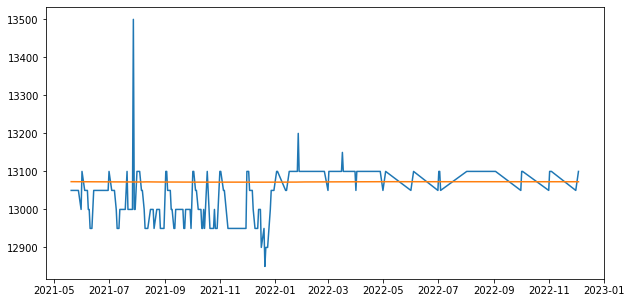

In [ ]:
prediction1_a1 = forecast_predict(model1_a, test_beras_super1_, time_size=win_size1, batch_size=5)

data_result1_a1 = prediction1_a1[(len(x_train))-win_size1:-1, -1 ]
data_result1_a1 = scal_range.inverse_transform(data_result1_a1.reshape(-1, 1))
data_result1_a1 = data_result1_a1.reshape(-1)
mae1_a1 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_a1)
mape1_a1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_a1)
mse1_a1 = tf.keras.metrics.mean_squared_error(x_test, data_result1_a1)

rmse1_a1 = math.sqrt(mse1_a1.numpy())
print(mae1_a1.numpy(), mape1_a1.numpy(), rmse1_a1)

data_new_beras_super11_a1 = pd.DataFrame()
data_new_beras_super11_a1['actual'] = x_test
data_new_beras_super11_a1['prediction'] = data_result1_a1
data_new_beras_super11_a1.to_csv('beras_super1_model2_sgd_type2.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_beras_super11_a1.actual)
plt.plot(y_test, data_new_beras_super11_a1.prediction)
data_new_beras_super11_a1

#### Type 3

In [ ]:
history1_a2 = model1_a.fit(train_step2, epochs=15, validation_data=val_step)

Epoch 1/15
84/84 [==============================] - 2s 17ms/step - loss: 0.0025 - mae: 0.0310 - mape: 6.4202 - val_loss: 0.0375 - val_mae: 0.1459 - val_mape: 52741660.0000
Epoch 2/15
84/84 [==============================] - 1s 16ms/step - loss: 0.0025 - mae: 0.0304 - mape: 6.2596 - val_loss: 0.0371 - val_mae: 0.1447 - val_mape: 52530700.0000
Epoch 3/15
84/84 [==============================] - 1s 15ms/step - loss: 0.0025 - mae: 0.0300 - mape: 6.1583 - val_loss: 0.0368 - val_mae: 0.1439 - val_mape: 52388912.0000
Epoch 4/15
84/84 [==============================] - 1s 15ms/step - loss: 0.0025 - mae: 0.0299 - mape: 6.1186 - val_loss: 0.0368 - val_mae: 0.1438 - val_mape: 52381592.0000
Epoch 5/15
84/84 [==============================] - 1s 15ms/step - loss: 0.0025 - mae: 0.0299 - mape: 6.1203 - val_loss: 0.0367 - val_mae: 0.1435 - val_mape: 52330484.0000
Epoch 6/15
84/84 [==============================] - 1s 15ms/step - loss: 0.0025 - mae: 0.0298 - mape: 6.1025 - val_loss: 0.0367 - val_mae: 0

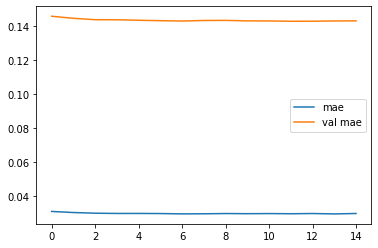

In [ ]:
mae1_a2 = history1_a2.history['mae']
val_mae1_a2 = history1_a2.history['val_mae']
epoch1_a2 = range(len(mae1_a2))

plt.plot(epoch1_a2, mae1_a2, label='mae')
plt.plot(epoch1_a2, val_mae1_a2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 1s 5ms/step
58.146973 0.44685778 75.50676449414979


,actual,prediction
0,13050,13071.633789
1,13050,13071.592773
2,13050,13071.582031
3,13050,13071.552734
4,13050,13071.523438
...,...,...
229,13100,13071.460938
230,13100,13071.462891
231,13100,13071.455078
232,13050,13071.457031


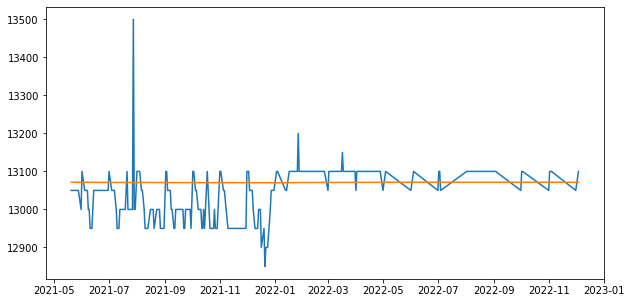

In [ ]:
prediction1_a2 = forecast_predict(model1_a, test_beras_super1_, time_size=win_size2, batch_size=5)

data_result1_a2 = prediction1_a2[(len(x_train))-win_size2:-1, -1 ]
data_result1_a2 = scal_range.inverse_transform(data_result1_a2.reshape(-1, 1))
data_result1_a2 = data_result1_a2.reshape(-1)
mae1_a2 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_a2)
mape1_a2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_a2)
mse1_a2 = tf.keras.metrics.mean_squared_error(x_test, data_result1_a2)

rmse1_a2 = math.sqrt(mse1_a2.numpy())
print(mae1_a2.numpy(), mape1_a2.numpy(), rmse1_a2)

data_new_beras_super11_a2 = pd.DataFrame()
data_new_beras_super11_a2['actual'] = x_test
data_new_beras_super11_a2['prediction'] = data_result1_a2
data_new_beras_super11_a2.to_csv('beras_super1_model2_sgd_type3.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_beras_super11_a2.actual)
plt.plot(y_test, data_new_beras_super11_a2.prediction)

data_new_beras_super11_a2

## model 2

### SGD

In [ ]:
model2= Sequential([
    Conv1D(8, kernel_size=5, 
                            activation='relu',strides=2,
                            padding='causal', input_shape=[None, 1]),
    tf.keras.layers.MaxPool1D(2, padding="same"),
    LSTM(14, return_sequences=True),
    Dropout(0.3),
    LSTM(64),
    Dense(24, activation='relu'),
    Dense(550, activation='relu'),
    Dense(1)
])

model2.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9), loss='mse', metrics=['mae', 'mape'])
model2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, None, 8)           48        
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 8)          0         
 )                                                               
                                                                 
 lstm_8 (LSTM)               (None, None, 14)          1288      
                                                                 
 dropout (Dropout)           (None, None, 14)          0         
                                                                 
 lstm_9 (LSTM)               (None, 64)                20224     
                                                                 
 dense_10 (Dense)            (None, 24)                1560      
                                                      

In [ ]:
# plot_model(model2, to_file='model3_plot.png', show_shapes=True, show_layer_names=True)

#### Type 1

In [ ]:
history2 = model2.fit(train_step, epochs=50, validation_data=val_step)

Epoch 1/50
44/44 [==============================] - 4s 34ms/step - loss: 0.2304 - mae: 0.4789 - mape: 94.7746 - val_loss: 0.1301 - val_mae: 0.3349 - val_mape: 6742795.0000
Epoch 2/50
44/44 [==============================] - 1s 20ms/step - loss: 0.1693 - mae: 0.4101 - mape: 81.1414 - val_loss: 0.0917 - val_mae: 0.2827 - val_mape: 13945037.0000
Epoch 3/50
44/44 [==============================] - 1s 14ms/step - loss: 0.1218 - mae: 0.3476 - mape: 68.7266 - val_loss: 0.0656 - val_mae: 0.2374 - val_mape: 20191906.0000
Epoch 4/50
44/44 [==============================] - 1s 14ms/step - loss: 0.0873 - mae: 0.2940 - mape: 58.0974 - val_loss: 0.0485 - val_mae: 0.2024 - val_mape: 25556280.0000
Epoch 5/50
44/44 [==============================] - 1s 14ms/step - loss: 0.0623 - mae: 0.2480 - mape: 48.9853 - val_loss: 0.0378 - val_mae: 0.1738 - val_mape: 30132508.0000
Epoch 6/50
44/44 [==============================] - 1s 14ms/step - loss: 0.0443 - mae: 0.2087 - mape: 41.1966 - val_loss: 0.0315 - val_m

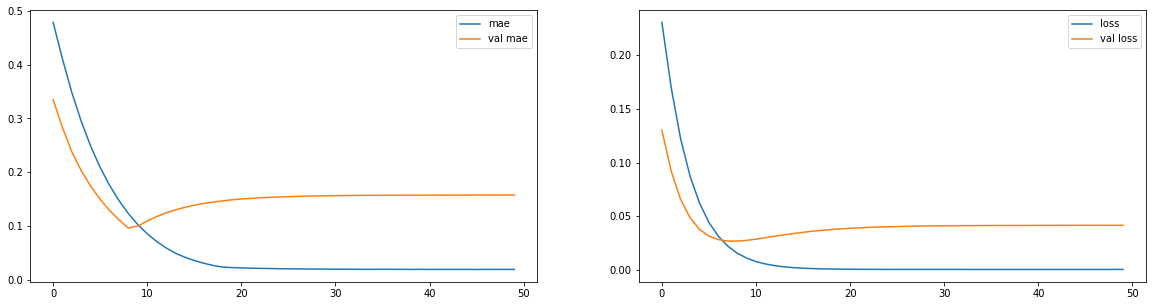

In [ ]:
mae2 = history2.history['mae']
val_mae2 = history2.history['val_mae']
loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']
epoch2 = range(len(mae2))

plt.figure(figsize=(20, 5))
plt.subplot(1,2, 1)
plt.plot(epoch2, mae2, label='mae')
plt.plot(epoch2, val_mae2, label='val mae')
plt.legend()
plt.subplot(1,2,2)
plt.plot(epoch2, loss2, label='loss')
plt.plot(epoch2, val_loss2, label='val loss')
plt.legend()
plt.show()

131/131 [==============================] - 1s 6ms/step
59.74037 0.45923716 78.11383670243704


,actual,prediction
0,13050,13076.314453
1,13050,13076.310547
2,13050,13076.312500
3,13050,13076.305664
4,13050,13076.310547
...,...,...
229,13100,13076.267578
230,13100,13076.271484
231,13100,13076.259766
232,13050,13076.261719


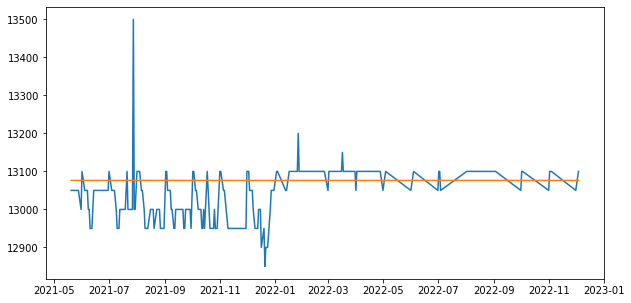

In [ ]:
prediction2 = forecast_predict(model2, test_beras_super1_, time_size=win_size, batch_size=5)

data_result2 = prediction2[(len(x_train))-win_size:-1, -1 ]
data_result2 = scal_range.inverse_transform(data_result2.reshape(-1, 1))
data_result2 = data_result2.reshape(-1)
mae2 = tf.keras.metrics.mean_absolute_error(x_test, data_result2)
mape2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2)
mse2 = tf.keras.metrics.mean_squared_error(x_test, data_result2)

rmse2 = math.sqrt(mse2.numpy())
print(mae2.numpy(), mape2.numpy(), rmse2)

data_new_beras_super12 = pd.DataFrame()
data_new_beras_super12['actual'] = x_test
data_new_beras_super12['prediction'] = data_result2
data_new_beras_super12.to_csv('beras_super1_medium_model3_sgd_type1.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_beras_super12.actual)
plt.plot(y_test, data_new_beras_super12.prediction)
data_new_beras_super12

#### Type2

In [ ]:
history2_1 = model2.fit(train_step1, epochs=50, validation_data=val_step)

Epoch 1/50
718/718 [==============================] - 5s 7ms/step - loss: 0.0040 - mae: 0.0454 - mape: 9.5297 - val_loss: 0.0382 - val_mae: 0.1484 - val_mape: 53073292.0000
Epoch 2/50
718/718 [==============================] - 5s 7ms/step - loss: 0.0039 - mae: 0.0441 - mape: 9.1522 - val_loss: 0.0383 - val_mae: 0.1486 - val_mape: 53109244.0000
Epoch 3/50
718/718 [==============================] - 5s 7ms/step - loss: 0.0039 - mae: 0.0444 - mape: 9.2132 - val_loss: 0.0381 - val_mae: 0.1480 - val_mape: 52995632.0000
Epoch 4/50
718/718 [==============================] - 5s 7ms/step - loss: 0.0039 - mae: 0.0440 - mape: 9.1176 - val_loss: 0.0382 - val_mae: 0.1484 - val_mape: 53067816.0000
Epoch 5/50
718/718 [==============================] - 5s 7ms/step - loss: 0.0039 - mae: 0.0441 - mape: 9.1367 - val_loss: 0.0384 - val_mae: 0.1489 - val_mape: 53148728.0000
Epoch 6/50
718/718 [==============================] - 5s 7ms/step - loss: 0.0039 - mae: 0.0442 - mape: 9.1728 - val_loss: 0.0386 - val_

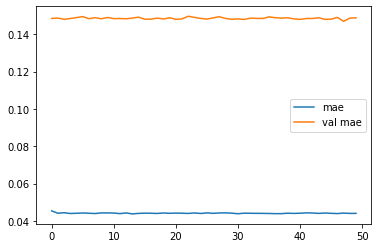

In [ ]:
mae2_1 = history2_1.history['mae']
val_mae2_1 = history2_1.history['val_mae']
epoch2_1 = range(len(mae2_1))

plt.plot(epoch2_1, mae2_1, label='mae')
plt.plot(epoch2_1, val_mae2_1, label='val mae')
plt.legend()
plt.show()

In [ ]:
prediction2_1 = forecast_predict(model2, test_beras_super1_, time_size=win_size1, batch_size=5)

data_result2_1 = prediction2_1[(len(x_train))-win_size1:-1, -1 ]
data_result2_1 = scal_range.inverse_transform(data_result2_1.reshape(-1, 1))
data_result2_1 = data_result2_1.reshape(-1)
mae2_1 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_1)
mape2_1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_1)
mse2_1 = tf.keras.metrics.mean_squared_error(x_test, data_result2_1)

rmse2_1 = math.sqrt(mse2_1.numpy())
print(mae2_1.numpy(), mape2_1.numpy(), rmse2_1)

data_new_beras_super12_1 = pd.DataFrame()
data_new_beras_super12_1['actual'] = x_test
data_new_beras_super12_1['prediction'] = data_result2_1
data_new_beras_super12_1.to_csv('beras_super1_model3_sgd_type2.csv')

data_new_beras_super12

199/199 [==============================] - 1s 3ms/step
58.852318 0.45232946 76.57198601948855


,actual,prediction
0,13050,13076.314453
1,13050,13076.310547
2,13050,13076.312500
3,13050,13076.305664
4,13050,13076.310547
...,...,...
229,13100,13076.267578
230,13100,13076.271484
231,13100,13076.259766
232,13050,13076.261719


#### Type 3

In [ ]:
history2_2 = model2.fit(train_step2, epochs=50, validation_data=val_step)

Epoch 1/50
84/84 [==============================] - 1s 13ms/step - loss: 0.0025 - mae: 0.0315 - mape: 6.4997 - val_loss: 0.0380 - val_mae: 0.1478 - val_mape: 52971252.0000
Epoch 2/50
84/84 [==============================] - 1s 11ms/step - loss: 0.0025 - mae: 0.0310 - mape: 6.3827 - val_loss: 0.0378 - val_mae: 0.1472 - val_mape: 52863068.0000
Epoch 3/50
84/84 [==============================] - 1s 11ms/step - loss: 0.0025 - mae: 0.0309 - mape: 6.3548 - val_loss: 0.0377 - val_mae: 0.1468 - val_mape: 52791644.0000
Epoch 4/50
84/84 [==============================] - 1s 11ms/step - loss: 0.0025 - mae: 0.0306 - mape: 6.2722 - val_loss: 0.0375 - val_mae: 0.1464 - val_mape: 52713204.0000
Epoch 5/50
84/84 [==============================] - 1s 11ms/step - loss: 0.0025 - mae: 0.0305 - mape: 6.2458 - val_loss: 0.0375 - val_mae: 0.1463 - val_mape: 52708648.0000
Epoch 6/50
84/84 [==============================] - 1s 11ms/step - loss: 0.0025 - mae: 0.0305 - mape: 6.2587 - val_loss: 0.0375 - val_mae: 0

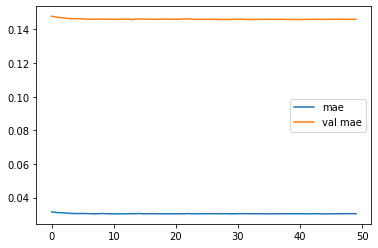

In [ ]:
mae2_2 = history2_2.history['mae']
val_mae2_2 = history2_2.history['val_mae']
epoch2_2 = range(len(mae2_2))

plt.plot(epoch2_2, mae2_2, label='mae')
plt.plot(epoch2_2, val_mae2_2, label='val mae')
plt.legend()
plt.show()

In [ ]:
prediction2_2 = forecast_predict(model2, test_beras_super1_, time_size=win_size2, batch_size=5)

data_result2_2 = prediction2_2[(len(x_train))-win_size2:-1, -1 ]
data_result2_2 = scal_range.inverse_transform(data_result2_2.reshape(-1, 1))
data_result2_2 = data_result2_2.reshape(-1)
mae2_2 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_2)
mape2_2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_2)
mse2_2 = tf.keras.metrics.mean_squared_error(x_test, data_result2_2)

rmse2_2 = math.sqrt(mse2_2.numpy())
print(mae2_2.numpy(), mape2_2.numpy(), rmse2_2)

data_new_beras_super12_2 = pd.DataFrame()
data_new_beras_super12_2['actual'] = x_test
data_new_beras_super12_2['prediction'] = data_result2_2
data_new_beras_super12_2.to_csv('beras_super1_model3_sgd-type3.csv')

data_new_beras_super12_2

181/181 [==============================] - 1s 4ms/step
58.49111 0.44951975 75.97577803258253


,actual,prediction
0,13050,13071.597656
1,13050,13071.598633
2,13050,13071.589844
3,13050,13071.588867
4,13050,13071.596680
...,...,...
229,13100,13071.610352
230,13100,13071.614258
231,13100,13071.605469
232,13050,13071.608398


### Adam

In [ ]:
model2_a= Sequential([
    Conv1D(16, kernel_size=2, 
                            activation='relu',strides=2,
                            padding='causal', input_shape=[None, 1]),
    tf.keras.layers.MaxPool1D(2, padding="same"),
    LSTM(24, return_sequences=True),
    Dropout(0.3),
    LSTM(80),
    Dense(24, activation='relu'),
    Dense(50, activation='relu'),
    Dense(1)
])

model2_a.compile(loss= 'mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=['mae', 'mape'])
model2_a.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, None, 16)          48        
                                                                 
 max_pooling1d_1 (MaxPooling  (None, None, 16)         0         
 1D)                                                             
                                                                 
 lstm_10 (LSTM)              (None, None, 24)          3936      
                                                                 
 dropout_1 (Dropout)         (None, None, 24)          0         
                                                                 
 lstm_11 (LSTM)              (None, 80)                33600     
                                                                 
 dense_13 (Dense)            (None, 24)                1944      
                                                      

#### type 1

In [ ]:
history2_a = model2_a.fit(train_step, epochs=50, validation_data=val_step)

Epoch 1/50
44/44 [==============================] - 5s 34ms/step - loss: 0.1502 - mae: 0.3797 - mape: 75.0872 - val_loss: 0.0409 - val_mae: 0.1832 - val_mape: 28508218.0000
Epoch 2/50
44/44 [==============================] - 1s 17ms/step - loss: 0.0112 - mae: 0.0799 - mape: 15.8075 - val_loss: 0.0298 - val_mae: 0.1163 - val_mape: 47436220.0000
Epoch 3/50
44/44 [==============================] - 1s 15ms/step - loss: 0.0014 - mae: 0.0307 - mape: 6.0574 - val_loss: 0.0318 - val_mae: 0.1257 - val_mape: 49046172.0000
Epoch 4/50
44/44 [==============================] - 1s 15ms/step - loss: 0.0011 - mae: 0.0272 - mape: 5.3863 - val_loss: 0.0321 - val_mae: 0.1269 - val_mape: 49252320.0000
Epoch 5/50
44/44 [==============================] - 1s 15ms/step - loss: 9.2000e-04 - mae: 0.0239 - mape: 4.7445 - val_loss: 0.0323 - val_mae: 0.1280 - val_mape: 49441268.0000
Epoch 6/50
44/44 [==============================] - 1s 15ms/step - loss: 9.7157e-04 - mae: 0.0245 - mape: 4.8654 - val_loss: 0.0324 - 

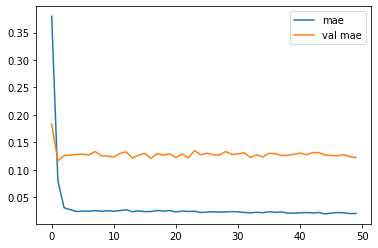

In [ ]:
mae2_a = history2_a.history['mae']
val_mae2_a = history2_a.history['val_mae']
epoch2_a = range(len(mae2_a))

plt.plot(epoch2_a, mae2_a, label='mae')
plt.plot(epoch2_a, val_mae2_a, label='val mae')
plt.legend()
plt.show()

In [ ]:
prediction2_a = forecast_predict(model2_a, test_beras_super1_, time_size=win_size, batch_size=5)

data_result2_a = prediction2_a[(len(x_train))-win_size:-1, -1 ]
data_result2_a = scal_range.inverse_transform(data_result2_a.reshape(-1, 1))
data_result2_a = data_result2_a.reshape(-1)
mae2_a = tf.keras.metrics.mean_absolute_error(x_test, data_result2_a)
mape2_a = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_a)
mse2_a = tf.keras.metrics.mean_squared_error(x_test, data_result2_a)

rmse2_a = math.sqrt(mse2_a.numpy())
print(mae2_a.numpy(), mape2_a.numpy(), rmse2_a)

data_new_beras_super12_a = pd.DataFrame()
data_new_beras_super12_a['actual'] = x_test
data_new_beras_super12_a['prediction'] = data_result2_a
data_new_beras_super12_a.to_csv('beras_super1_model3_adam-type1.csv')

data_new_beras_super12_a

131/131 [==============================] - 1s 6ms/step
57.768776 0.44385162 74.26323009235459


,actual,prediction
0,13050,13072.198242
1,13050,13072.375000
2,13050,13072.235352
3,13050,13072.082031
4,13050,13071.941406
...,...,...
229,13100,13069.503906
230,13100,13069.407227
231,13100,13069.577148
232,13050,13069.495117


#### Type 2

In [ ]:
history2_a1 = model2_a.fit(train_step1, epochs=50, validation_data=val_step)

Epoch 1/50
718/718 [==============================] - 5s 8ms/step - loss: 0.0047 - mae: 0.0445 - mape: 9.1106 - val_loss: 0.0345 - val_mae: 0.1364 - val_mape: 50964488.0000
Epoch 2/50
718/718 [==============================] - 5s 7ms/step - loss: 0.0044 - mae: 0.0447 - mape: 9.1102 - val_loss: 0.0373 - val_mae: 0.1452 - val_mape: 52528548.0000
Epoch 3/50
718/718 [==============================] - 5s 8ms/step - loss: 0.0042 - mae: 0.0439 - mape: 8.9920 - val_loss: 0.0388 - val_mae: 0.1499 - val_mape: 53324464.0000
Epoch 4/50
718/718 [==============================] - 5s 7ms/step - loss: 0.0040 - mae: 0.0429 - mape: 8.7858 - val_loss: 0.0384 - val_mae: 0.1486 - val_mape: 53125752.0000
Epoch 5/50
718/718 [==============================] - 5s 7ms/step - loss: 0.0039 - mae: 0.0419 - mape: 8.5653 - val_loss: 0.0400 - val_mae: 0.1531 - val_mape: 53915328.0000
Epoch 6/50
718/718 [==============================] - 5s 7ms/step - loss: 0.0039 - mae: 0.0433 - mape: 8.8957 - val_loss: 0.0426 - val_

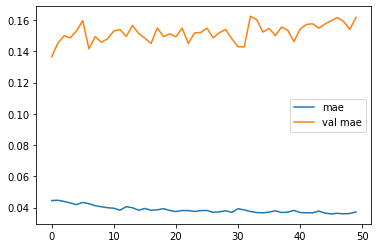

In [ ]:
mae2_a1 = history2_a1.history['mae']
val_mae2_a1 = history2_a1.history['val_mae']
epoch2_a1 = range(len(mae2_a1))

plt.plot(epoch2_a1, mae2_a1, label='mae')
plt.plot(epoch2_a1, val_mae2_a1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 3ms/step
58.805588 0.45202324 76.8615937243286


,actual,prediction
0,13050,13079.477539
1,13050,13079.798828
2,13050,13079.620117
3,13050,13079.281250
4,13050,13079.112305
...,...,...
229,13100,13078.342773
230,13100,13078.401367
231,13100,13078.454102
232,13050,13078.424805


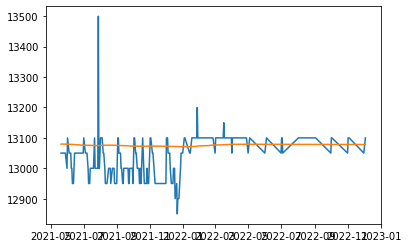

In [ ]:
prediction2_a1 = forecast_predict(model2_a, test_beras_super1_, time_size=win_size1, batch_size=5)

data_result2_a1 = prediction2_a1[(len(x_train))-win_size1:-1, -1 ]
data_result2_a1 = scal_range.inverse_transform(data_result2_a1.reshape(-1, 1))
data_result2_a1 = data_result2_a1.reshape(-1)
mae2_a1 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_a1)
mape2_a1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_a1)
mse2_a1 = tf.keras.metrics.mean_squared_error(x_test, data_result2_a1)

rmse2_a1 = math.sqrt(mse2_a1.numpy())
print(mae2_a1.numpy(), mape2_a1.numpy(), rmse2_a1)

data_new_beras_super12_a1 = pd.DataFrame()
data_new_beras_super12_a1['actual'] = x_test
data_new_beras_super12_a1['prediction'] = data_result2_a1
data_new_beras_super12_a1.to_csv('beras_super1_model3_adam-type2.csv')

plt.plot(y_test, data_new_beras_super12_a1.actual)
plt.plot(y_test, data_new_beras_super12_a1.prediction)
data_new_beras_super12_a1

#### Type 3

In [ ]:
history2_a2 = model2_a.fit(train_step2, epochs= 50, validation_data=val_step)

Epoch 1/50
84/84 [==============================] - 1s 13ms/step - loss: 0.0024 - mae: 0.0281 - mape: 5.7417 - val_loss: 0.0421 - val_mae: 0.1591 - val_mape: 54512080.0000
Epoch 2/50
84/84 [==============================] - 1s 11ms/step - loss: 0.0024 - mae: 0.0282 - mape: 5.7709 - val_loss: 0.0393 - val_mae: 0.1520 - val_mape: 53279712.0000
Epoch 3/50
84/84 [==============================] - 1s 11ms/step - loss: 0.0023 - mae: 0.0274 - mape: 5.5480 - val_loss: 0.0424 - val_mae: 0.1600 - val_mape: 54650176.0000
Epoch 4/50
84/84 [==============================] - 1s 11ms/step - loss: 0.0023 - mae: 0.0274 - mape: 5.5808 - val_loss: 0.0417 - val_mae: 0.1583 - val_mape: 54356468.0000
Epoch 5/50
84/84 [==============================] - 1s 11ms/step - loss: 0.0024 - mae: 0.0281 - mape: 5.7422 - val_loss: 0.0418 - val_mae: 0.1586 - val_mape: 54393696.0000
Epoch 6/50
84/84 [==============================] - 1s 11ms/step - loss: 0.0024 - mae: 0.0277 - mape: 5.6566 - val_loss: 0.0410 - val_mae: 0

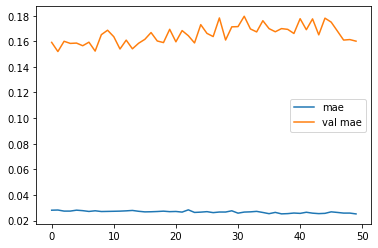

In [ ]:
mae2_a2 = history2_a2.history['mae']
val_mae2_a2 = history2_a2.history['val_mae']
epoch2_a2 = range(len(mae2_a2))

plt.plot(epoch2_a2, mae2_a2, label='mae')
plt.plot(epoch2_a2, val_mae2_a2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 1s 4ms/step
53.94228 0.41437927 70.81114159111898


,actual,prediction
0,13050,13066.310547
1,13050,13065.901367
2,13050,13066.062500
3,13050,13066.056641
4,13050,13065.844727
...,...,...
229,13100,13072.364258
230,13100,13072.187500
231,13100,13071.893555
232,13050,13072.294922


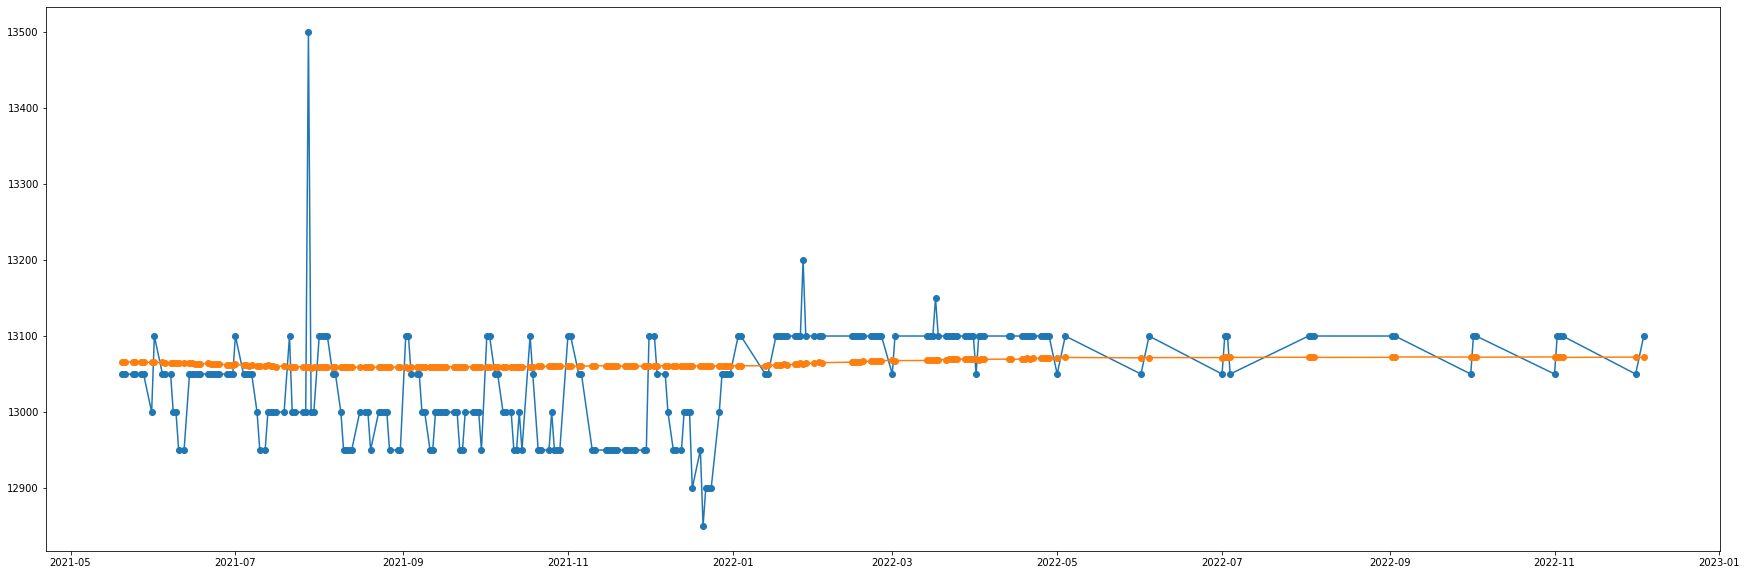

In [ ]:
prediction2_a2 = forecast_predict(model2_a, test_beras_super1_, time_size=win_size2, batch_size=5)

data_result2_a2 = prediction2_a2[(len(x_train))-win_size2:-1, -1 ]
data_result2_a2 = scal_range.inverse_transform(data_result2_a2.reshape(-1, 1))
data_result2_a2 = data_result2_a2.reshape(-1)
mae2_a2 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_a2)
mape2_a2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_a2)
mse2_a2 = tf.keras.metrics.mean_squared_error(x_test, data_result2_a2)

rmse2_a2 = math.sqrt(mse2_a2.numpy())
print(mae2_a2.numpy(), mape2_a2.numpy(), rmse2_a2)

data_new_beras_super12_a2 = pd.DataFrame()
data_new_beras_super12_a2['actual'] = x_test
data_new_beras_super12_a2['prediction'] = data_result2_a2
data_new_beras_super12_a2.to_csv('beras_super1_model3_adam_type3.csv')

plt.figure(figsize=(30, 10))
plt.plot(y_test,data_new_beras_super12_a2.actual, '-o')
plt.plot(y_test,data_new_beras_super12_a2.prediction, '-o')
data_new_beras_super12_a2